<center>
    <h1>Binary Logististic Regression</h1>
    <h2>by Rebecca Hinrichs</h2>
    <h4>23 Feb 23</h4>
</center>

---
<h3>Questions:</h3><br>
1. Why is output of $\sigma$ in the interval (0, 1)?

It represents the probability that an instance belongs to a particular class, where `0` indicates that it definitely does not (meaning $0\%$ probability) and `1` that it does (meaning $100\%$ probability).

2. Why the output of $\sigma$ cannot equal 0 or 1?

The formula is $\sigma(z) = (1 + e^{-z})^{-1}$. The variable $z$ can be any number, but because $e^{ 0}=1$ and $e^{\text{ any number}}$ is always positive and will only increase the overall denominator, approaching $0$ but never arriving, $\sigma$ will always be a positive number but never equal to $0$ or $1$.

3. For what value of z is $\sigma$(z) = 0.5?

When $z=0$, we have $\sigma(0)=(1+e^{0})^{-1}=(1+1)^{-1}=\frac{1}{2}=0.5$

4. Show that $\sigma$'(z) = $\sigma$(z) · (1 − $\sigma$(z)).

We recall that $\sigma(z) = (1 + e^{-z})^{-1}$ and let $u=(1+e^{-z})$.<br>
Therefore:
$$
\frac{1}{1 + e^{-z}}=\frac{1}{u} \ \ \text{using substitution }\\
\frac{d}{du}\frac{1}{u}=-\frac{1}{u^{2}} \ \ \text{calculate the derivative of }u\\
\frac{d}{du}=-\frac{u}{u^{2}} \ \ \text{multiplying both sides by }u\\
=-\frac{\frac{d}{dz}(1+e^{-z})}{(1+e^{-z})^{2}} \ \ \text{unsubstitute }u\\
=-\frac{(-1)(e^{-z})}{(1+e^{-z})^{2}} \ \ \text{implement the derivative of }z\\
=\frac{e^{-z}}{(1+e^{-z})^{2}} \ \ \text{multiplying out terms}\\
\text{given that }\frac{1}{(1+e^{-z})}=\sigma(z) \\
\text{ and that } \ \frac{(1+e^{-z}-1)}{(1+e^{-z})}=\frac{(1+e^{-z})}{(1+e^{-z})}-\frac{1}{(1+e^{-z})}=1-\sigma(z)\\ \ \\
\text{we have }\sigma'(z)=\sigma(z)*(1-\sigma(z))
$$</align>

---
### Logistic Regression:

Use `HR.csv` data set and consider column `left` to be the target variable with `1` meaning the person left the company and `0` meaning that the person did not leave the company.<br>
– Investigate using various graphs/charts how given features affect this target variable.<br>
– Choose several features and build the `sklearn` logistic regression model predicting the target variable `left`.<br>
– Discuss the model performance (the confusion matrix and the classification report) on the test set.

In [197]:
# Import Libraries & Dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# We have some warnings from our correlation matrices for using dummy vars
import warnings
warnings.filterwarnings("ignore")

# Import Dataset
data = pd.read_excel("HR_Employee_Data.xlsx")
data.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,0.38,0.53,2,157,3,0,1,0,sales,low
1,IND28133,0.80,0.86,5,262,6,0,1,0,sales,medium
2,IND07164,0.11,0.88,7,272,4,0,1,0,sales,medium
3,IND30478,0.72,0.87,5,223,5,0,1,0,sales,low
4,IND24003,0.37,0.52,2,159,3,0,1,0,sales,low


In [198]:
# Split target variable from remaining data
y = data['left']
X = data.drop(['Emp_Id','left'], axis=1)

# Split the training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

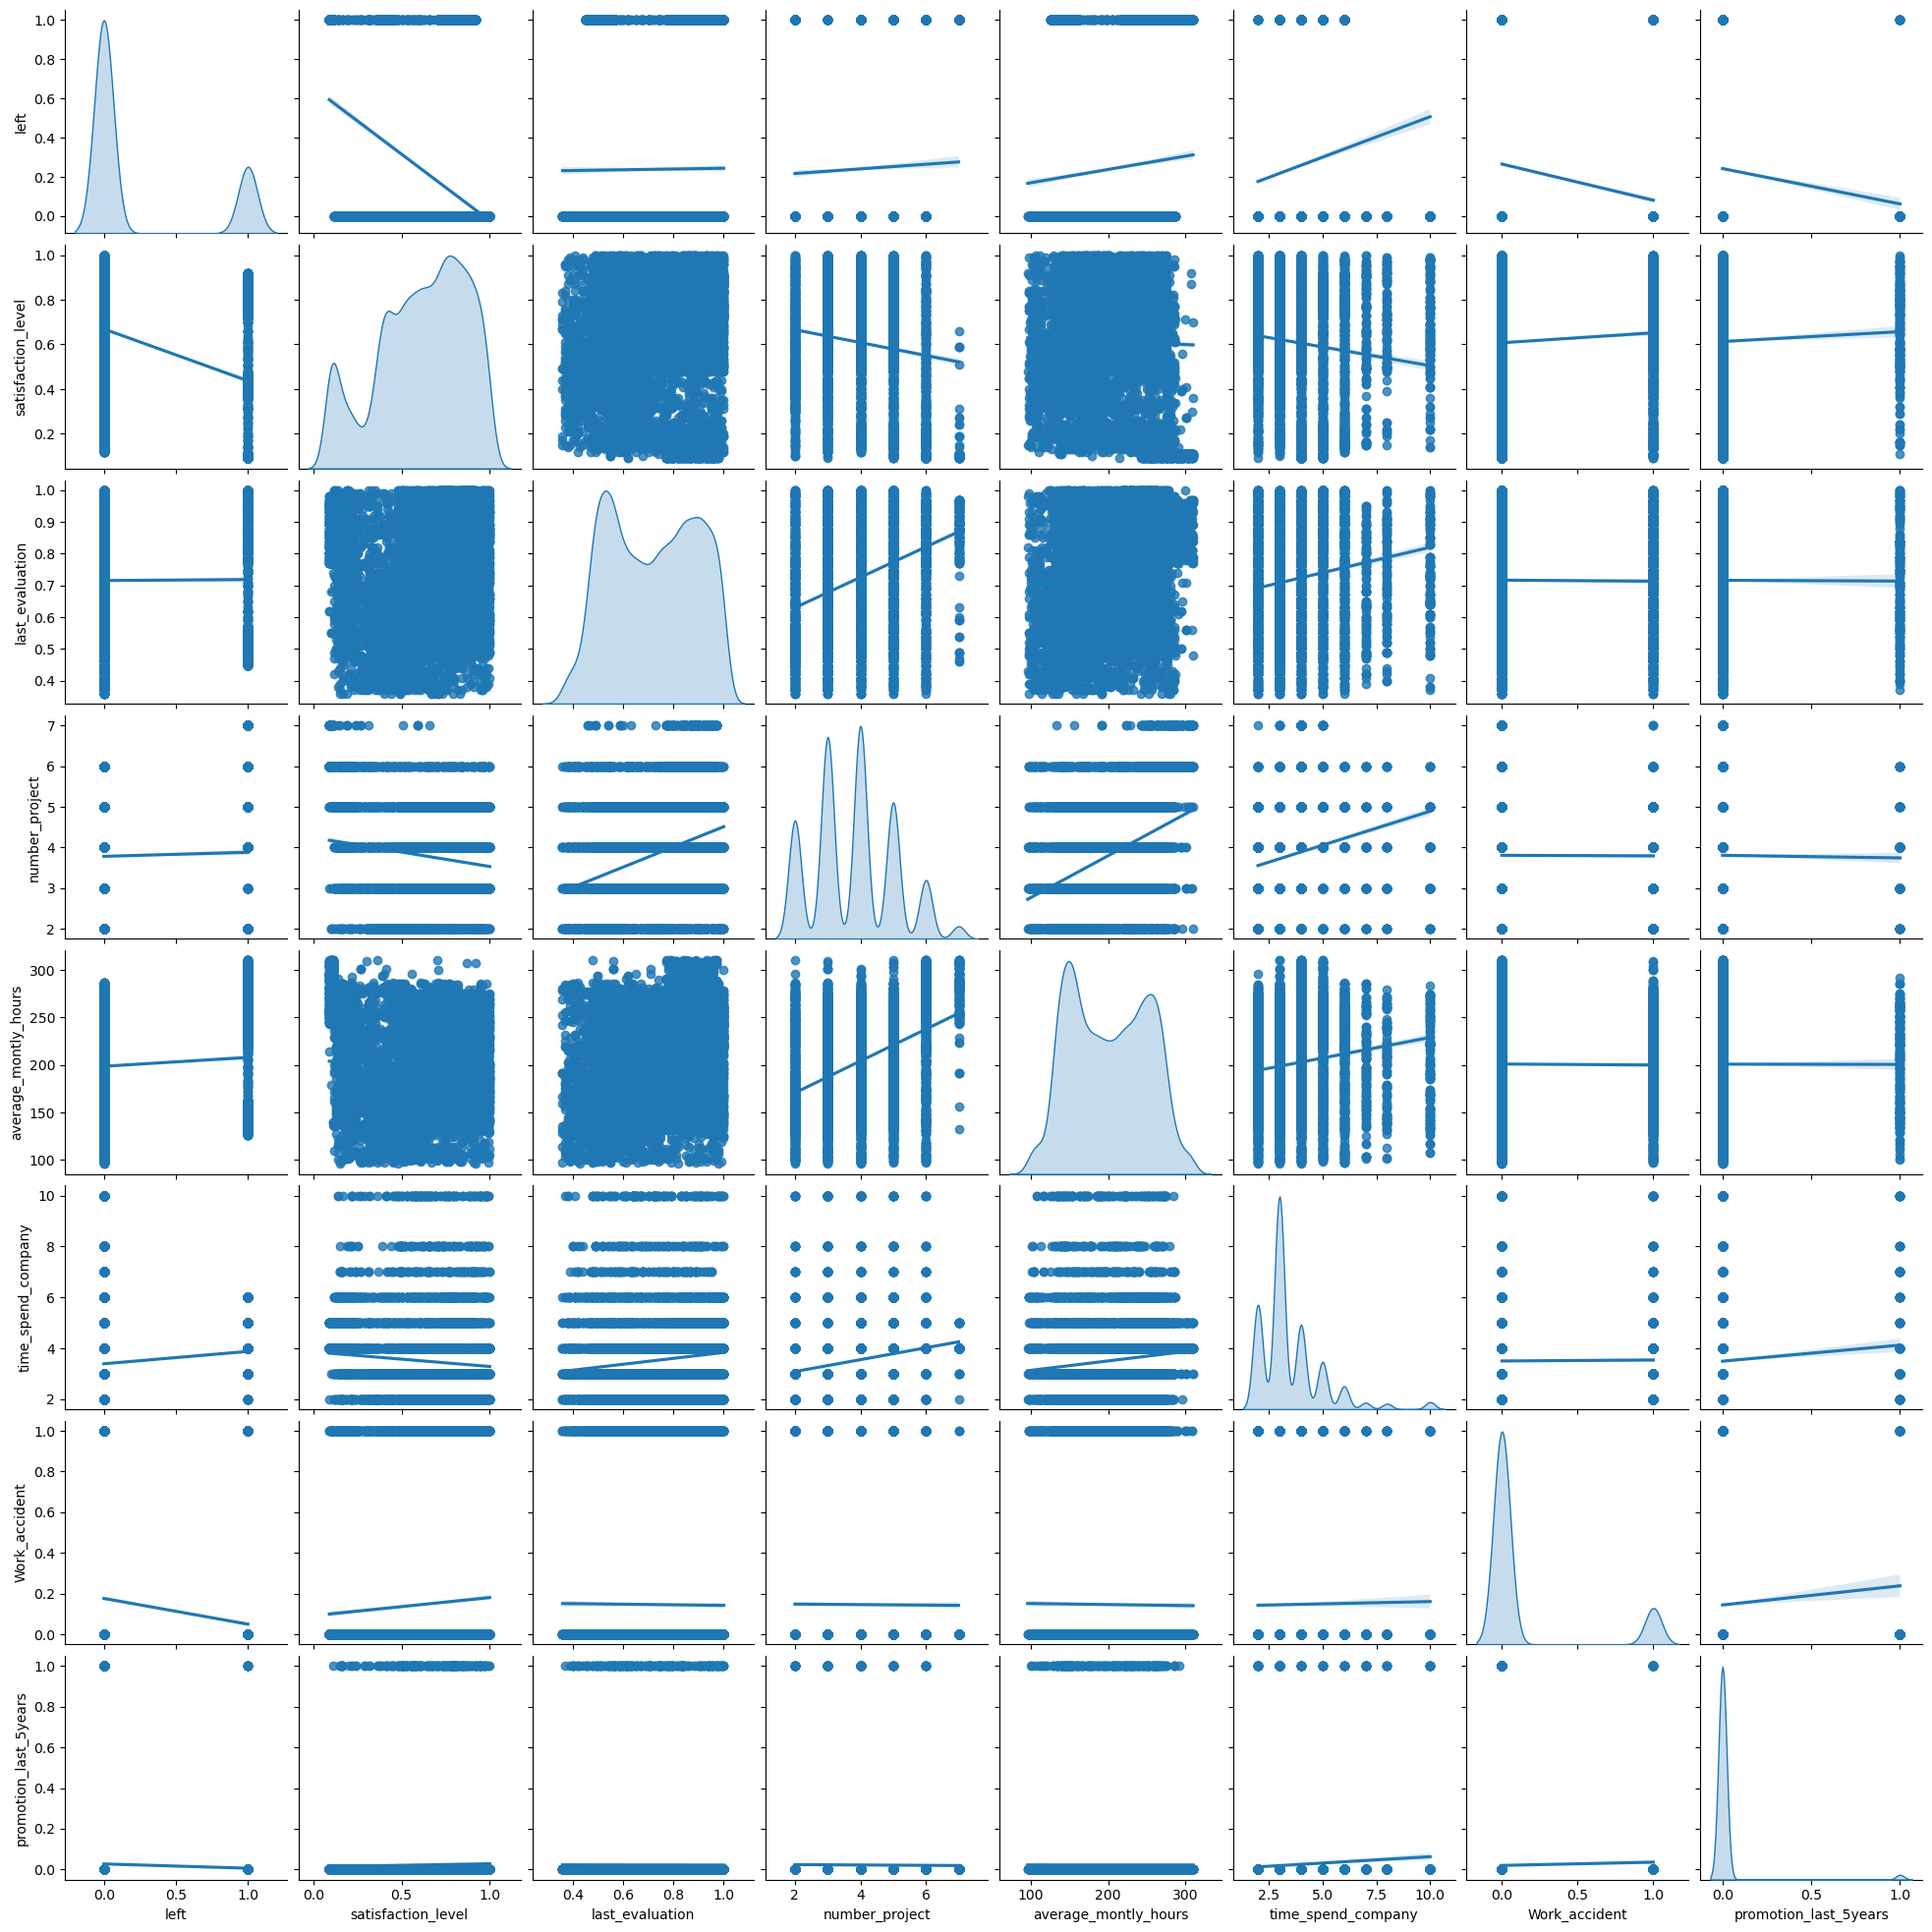

In [199]:
# Observe variable distributions & the pairwise relationships between them
train_dataset = X_train.copy()
train_dataset.insert(0, 'left', y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [201]:
# Observe column names and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Emp_Id                 14999 non-null  object 
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   Department             14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 1.3+ MB


In [204]:
# Assign non-ordinal numerical values to categorical features using One-Hot Encoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Department','salary','Work_accident','promotion_last_5years']
numerical_columns = ['satisfaction_level','last_evaluation','number_project',
                     'average_montly_hours','time_spend_company']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (MinMaxScaler(), numerical_columns),
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

# Use a ridge regressor with a very small regularization to model the logarithm of 'left'
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
import scipy as sp

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [ ]:
# Build the model
model.fit(X_train, y_train)

In [ ]:
# The best alpha (learning rate) hyperparameter returned
model[-1].regressor_.alpha_

In [ ]:
# Analyze the performance of the training vs testing models
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

# Demonstrate model performance
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [ ]:
# Evaluate weight distributions of coefficients
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

---
Testing above approach against Scikit-Learn's Logistic Regression modeler...

In [242]:
# Import Libraries & Dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# We have some warnings from our correlation matrices for using dummy vars
import warnings
warnings.filterwarnings("ignore")

# Import Dataset
data = pd.read_excel("HR_Employee_Data.xlsx")
data.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,0.38,0.53,2,157,3,0,1,0,sales,low
1,IND28133,0.80,0.86,5,262,6,0,1,0,sales,medium
2,IND07164,0.11,0.88,7,272,4,0,1,0,sales,medium
3,IND30478,0.72,0.87,5,223,5,0,1,0,sales,low
4,IND24003,0.37,0.52,2,159,3,0,1,0,sales,low


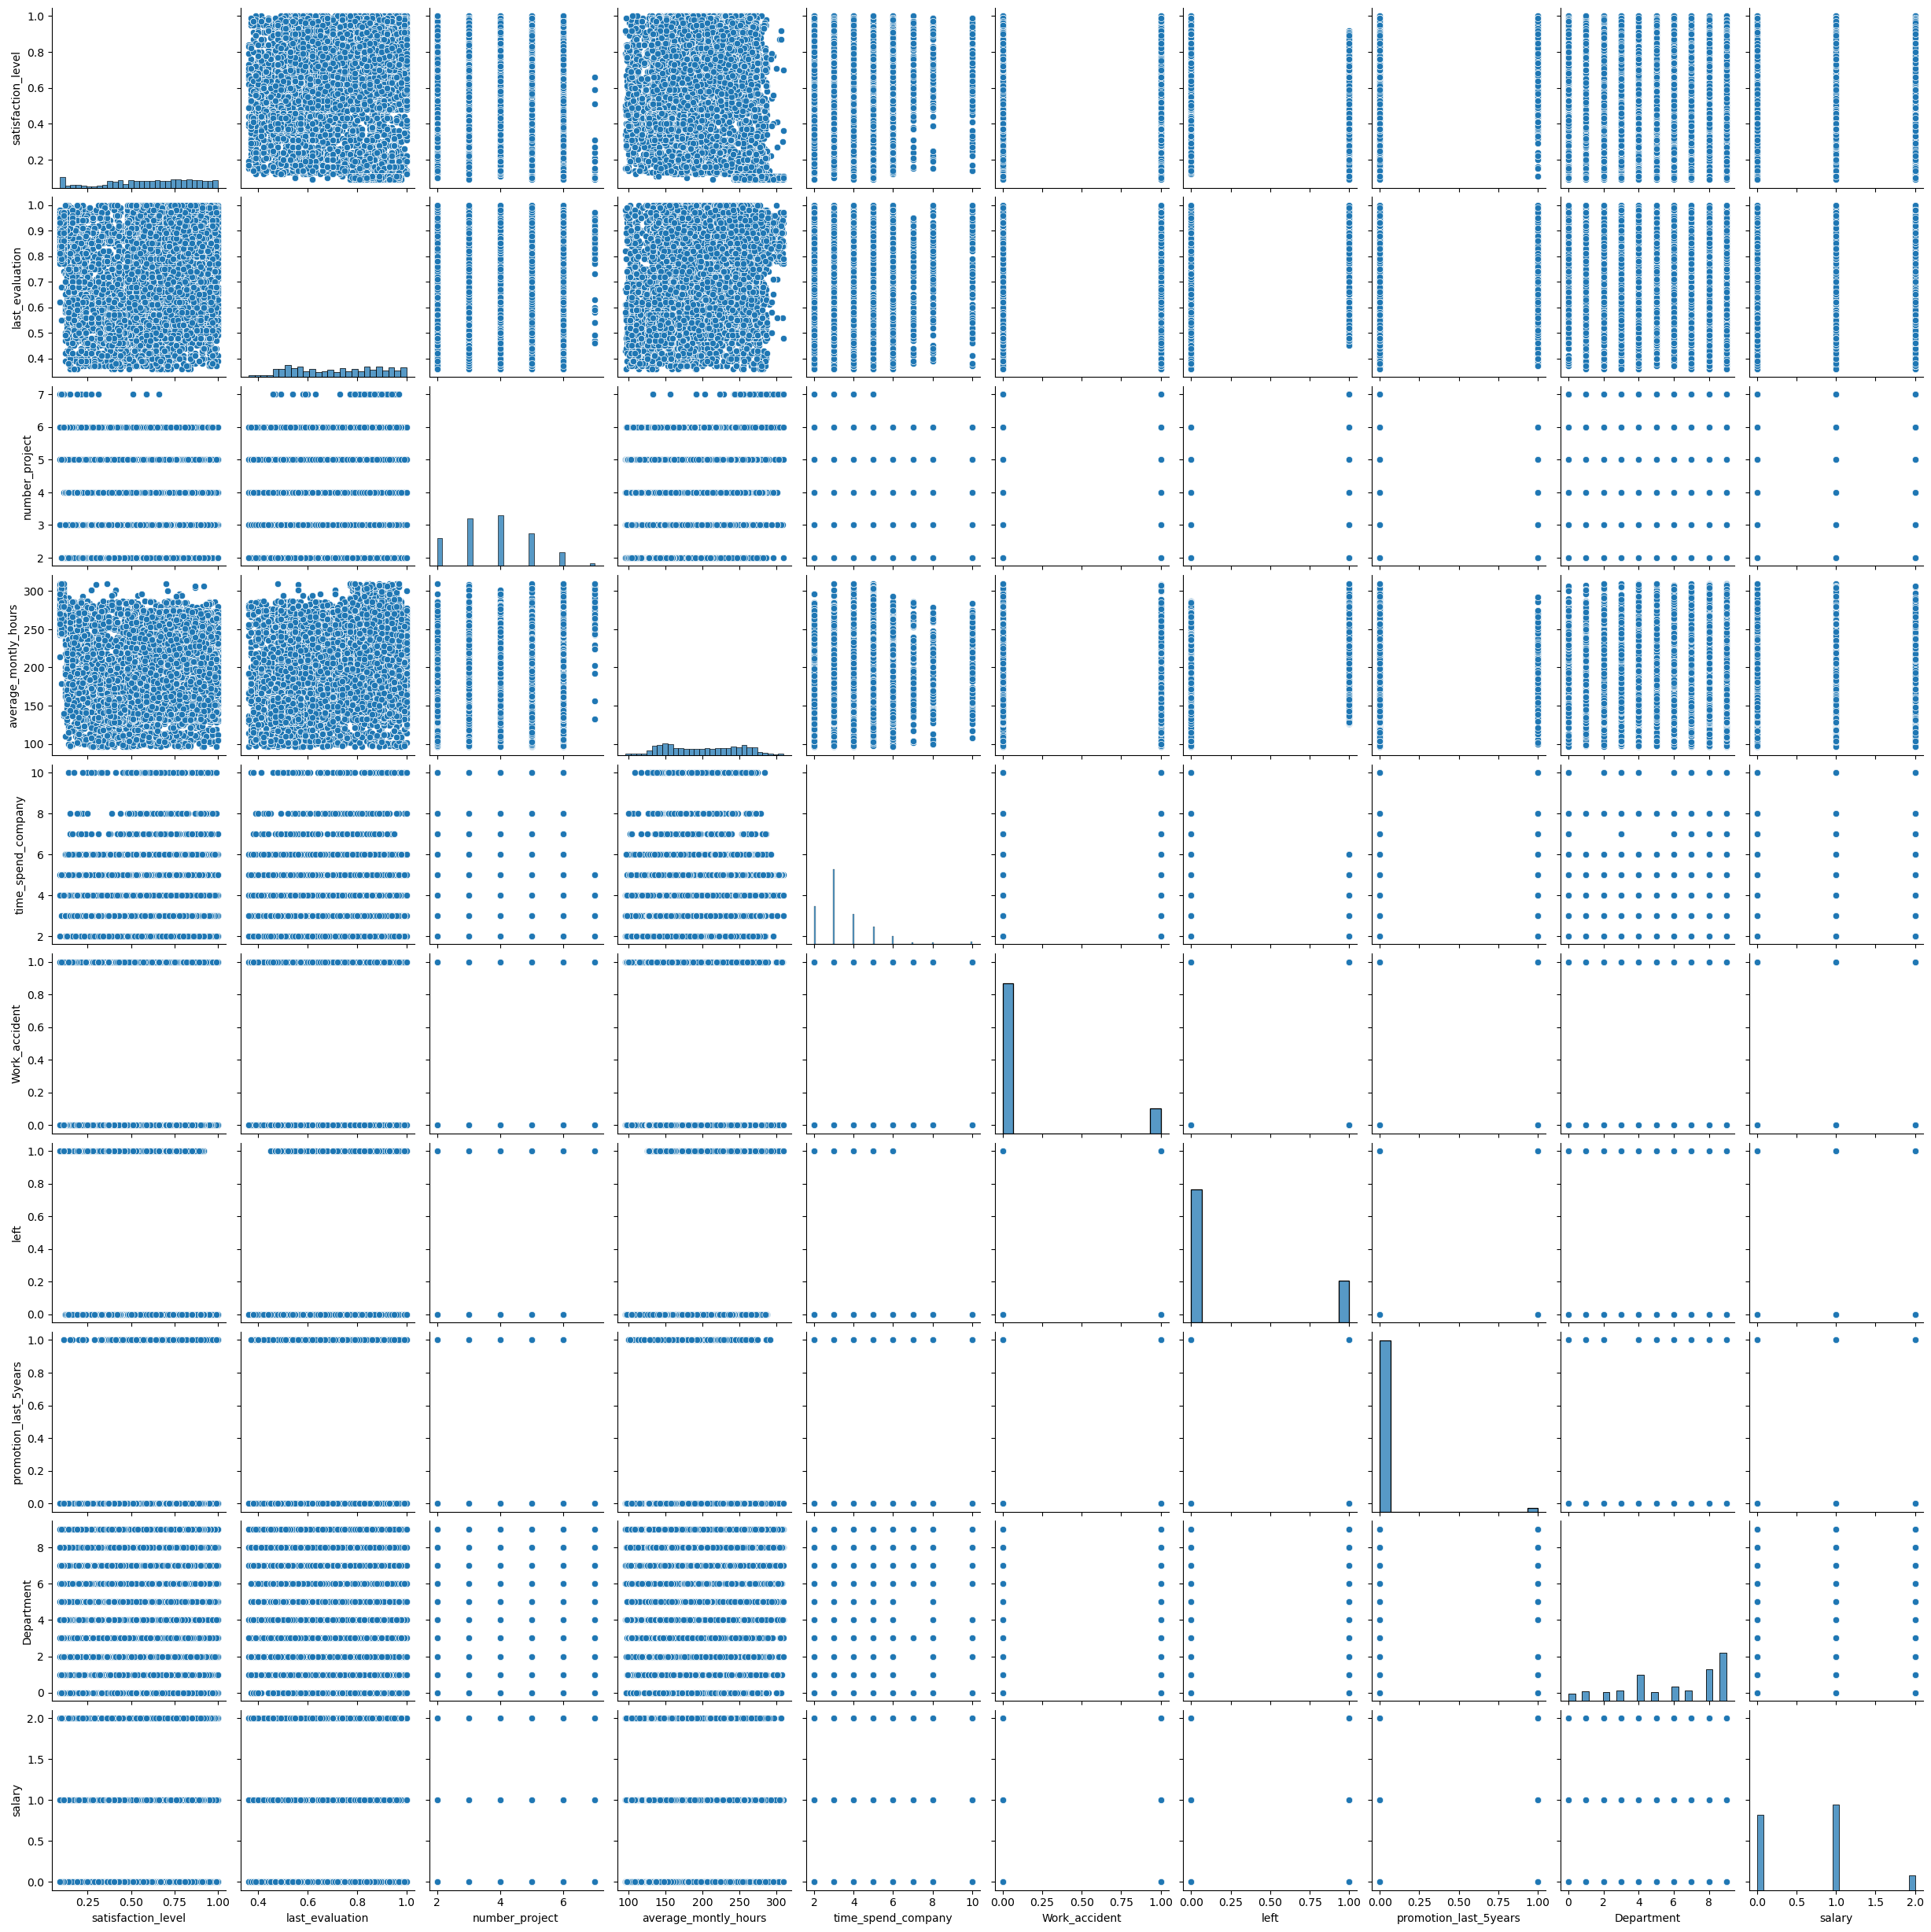

In [83]:
# We will use a pairplot to find the most strongly-correlated variables compared to 'm\\left'
sns.pairplot(data)

<AxesSubplot: >

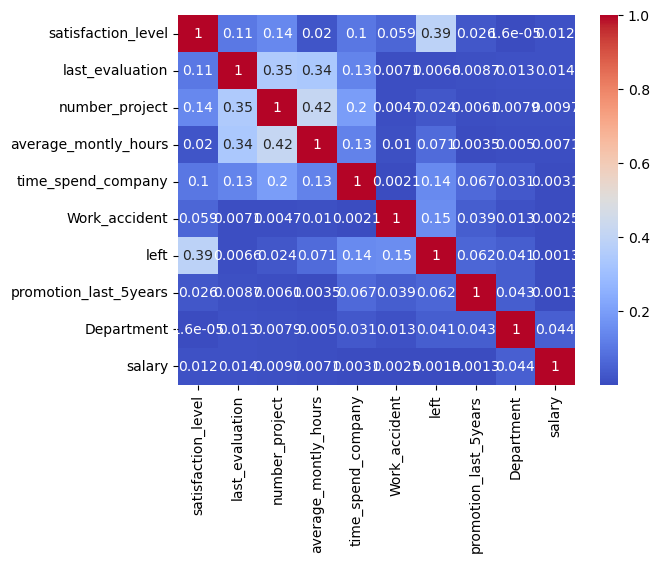

In [84]:
# We will use a heatmap to confirm the most strongly-correlated variables compared to 'm\\left'
sns.heatmap(data=abs(data.corr()), annot=True, cmap='coolwarm')

In [244]:
# We can also see the most strongly-correlated variables compared to 'left'
abs(data.corr())['left']

satisfaction_level       0.388375
last_evaluation          0.006567
number_project           0.023787
average_montly_hours     0.071287
time_spend_company       0.144822
Work_accident            0.154622
left                     1.000000
promotion_last_5years    0.061788
Department               0.041013
salary                   0.001294
Name: left, dtype: float64

Given these results, it appears `last_evaluation` and `number_project` are minimally-correlated to `left`. `promotion_last_5years` and `average_montly_hours` also appear to be negligible contributors. We'll construct our Logistic Regression Model with variables accounting in total to $80\%$ contribution to `left`. Also, `Emp_Id` is unrelated for our purposes.

In [245]:
# Separate target from coefficient variables; assign to arrays
X = data.drop(['Emp_Id','left'], axis=1)
y = data['left'].to_numpy()
print('Logistic Model correlation columns are:\n', 
      [i for i in X.columns])

Logistic Model correlation columns are:
 ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'Department', 'salary']


In [246]:
X_copy = X.copy()

In [249]:
# Replace categorical labels with dummy variables
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

binary_columns = ['Work_accident','promotion_last_5years']
categorical_columns = ['Department','salary']
numerical_columns = ['satisfaction_level','last_evaluation','number_project',
                     'average_montly_hours','time_spend_company']

preprocessor = make_column_transformer(
    (OneHotEncoder(), binary_columns),
    (OneHotEncoder(), categorical_columns),
    (MinMaxScaler(), numerical_columns),
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

preprocessor.fit_transform(X)
LabelBinarizer().fit_transform(y)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [250]:
# Next we'll ensure each variable gets scaled independently
print("We'll double-check the scaling worked:\n", X.sample(10))

We'll double-check the scaling worked:
        satisfaction_level  last_evaluation  number_project  \
13695                0.78             0.65               3   
9291                 0.57             0.65               4   
805                  0.36             0.62               4   
6199                 0.81             0.51               4   
6818                 0.87             0.92               4   
4448                 0.97             0.74               3   
13990                0.79             0.61               4   
7235                 0.72             0.71               3   
6675                 0.40             0.86               2   
12182                0.89             0.99               5   

       average_montly_hours  time_spend_company  Work_accident  \
13695                   139                   3              0   
9291                    265                   3              0   
805                     237                   2              0   
6199         

In [251]:
# Split the training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, 
                                                    test_size=0.3, random_state=42)

In [252]:
# Fit the prediction model using Multiple Linear Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
b = log_reg.intercept_
w = log_reg.coef_
print("\nThe logistic regression model based on the training data is \n")
print(f"h(x) = {np.round(w[0][0],5)}*satisfaction_level + "\
      f"{np.round(w[0][1],5)}*average_montly_hours + "\
      f"{np.round(w[0][2],5)}*time_spend_company + "\
      f"{np.round(w[0][3],5)}*Work_accident + "\
      f"{np.round(w[0][4],5)}*promotion_last_5years + "\
      f"{np.round(w[0][5],5)}*Department + "\
      f"{np.round(w[0][6],5)}*salary + "\
      f"{np.round(b[0],5)}\n")


The logistic regression model based on the training data is 

h(x) = -4.21511*satisfaction_level + 0.64196*average_montly_hours + -0.28395*time_spend_company + 0.00451*Work_accident + 0.21789*promotion_last_5years + -1.44122*Department + -0.98546*salary + 0.01389



In [151]:
# # Display graphic of Learned Logistic Regression Model
# plt.figure(figsize = (8, 6))
# plt.xlim((0, 100))
# plt.scatter(range(len(X_train)), y_train)
# domain = np.linspace(0, 100, 100)
# plt.plot(domain, log_reg.predict(X_test), color="red")
# plt.xlabel("age", fontsize = 15)
# plt.title("The Learned Logistic Curve", fontsize = 18)
# plt.show()

In [253]:
print('Training model accuracy:', log_reg.score(X_train, y_train))
print('Testing model accuracy:', log_reg.score(X_test, y_test))

Training model accuracy: 0.7677874083246023
Testing model accuracy: 0.7593333333333333


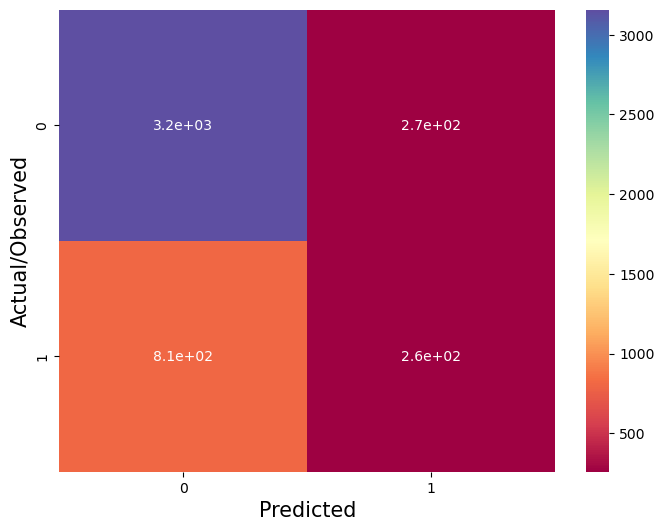

In [254]:
# Display confusion matrix as a heat map
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [255]:
confusion_matrix(y_test, y_pred)

array([[3157,  271],
       [ 812,  260]], dtype=int64)

In [256]:
# Display classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3428
           1       0.49      0.24      0.32      1072

    accuracy                           0.76      4500
   macro avg       0.64      0.58      0.59      4500
weighted avg       0.72      0.76      0.73      4500



**<center>Conclusion:**</center>
We fit a Logistic Regression Model with 9 of our 10 features, applying preprocessing techniques to each column per its data type. Our model shows a strongest correlation between response `left` and variables `satisfaction_level`, `Work_accident` and `time_spend_company`. Our F1 score is $76\%$, due to a high .8 Precision and .92 Recall rates for having not left the company (F1 score of .85) and rather low .49 Precision and .24 Recall rates for having left the company (F1 Score of .32). Our high Recall rate of tenured employees reflects a good minimization of False Negatives- in other words, we more correctly than not predicted an employee would leave the company when they actually did not. However our low Recall rate of departed employees is rather alarming at only .24- indicating our model performs rather poorly in predicting an employee would leave the company when in fact they did not. If our model may best favor Accuracy over an F1 score, then we find we have much to do yet in fine-tuning our Logistic Model to improve model performance.